## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Support Vector Classification 

## The Pima Indian diabetes

We want to predict whether a vector of text features corresponds to a patient having diabetes

### Attribute Information:

Patterns have 8 numeric features plus a 0-1 class label.

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 


More details and actual data available in https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Loading Data

The dataset can be obtained from many sources,although perhaps with different feature names. An example is

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [4]:
f_name = '..\\pima.csv'
df_pima = pd.read_csv(f_name, sep=',')

print( "num_rows: %d\tnum_columns: %d\n" % (df_pima.shape[0], df_pima.shape[1]) )
print( "Column names:\n", list(df_pima.columns) )

vars_pima   = list(df_pima.columns[ : -1])
target_pima = df_pima.columns[-1]

num_rows: 768	num_columns: 9

Column names:
 ['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age', 'label']


## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

### Descriptive analysis

In [5]:
df_pima.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
numPregnant,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00
glucose,768.0,120.89,31.97,0.00,99.00,117.00,140.25,199.00
bloodPress,768.0,69.11,19.36,0.00,62.00,72.00,80.00,122.00
skinThick,768.0,20.54,15.95,0.00,0.00,23.00,32.00,99.00
insulin,768.0,79.80,115.24,0.00,0.00,30.50,127.25,846.00
massIndex,768.0,31.99,7.88,0.00,27.30,32.00,36.60,67.10
pedigree,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42
age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00
label,768.0,0.35,0.48,0.00,0.00,0.00,1.00,1.00


There are features with strange minimum vales, in fact, all but `numPregnant, pedigree` or `age`.

We have to decide what to do with them and the first step is to count these strange values.

In [6]:
for feature in ["glucose", "bloodPress", "skinThick", "insulin", "massIndex"]:
    print("valores 0 in %s:\t%d" % (feature, (df_pima[feature].values == 0.).sum()))

valores 0 in glucose:	5
valores 0 in bloodPress:	35
valores 0 in skinThick:	227
valores 0 in insulin:	374
valores 0 in massIndex:	11


We are going to drop the 0 values in `glucose, bloodPress` and `massIndex`.

In [7]:
idx_ok = df_pima['glucose'].values > 0.
idx_ok = np.logical_and(idx_ok, df_pima['bloodPress'].values > 0.)
idx_ok = np.logical_and(idx_ok, df_pima['massIndex'].values > 0.)

df_pima = df_pima.loc[ idx_ok ]

We re-describe the new DataFrame.

In [8]:
df_pima.describe().round(decimals=3).T

,count,mean,std,min,25%,50%,75%,max
numPregnant,724.0,3.866,3.363,0.000,1.000,3.000,6.000,17.00
glucose,724.0,121.883,30.750,44.000,99.750,117.000,142.000,199.00
bloodPress,724.0,72.401,12.380,24.000,64.000,72.000,80.000,122.00
skinThick,724.0,21.443,15.733,0.000,0.000,24.000,33.000,99.00
insulin,724.0,84.494,117.017,0.000,0.000,48.000,130.500,846.00
massIndex,724.0,32.467,6.889,18.200,27.500,32.400,36.600,67.10
pedigree,724.0,0.475,0.332,0.078,0.245,0.379,0.628,2.42
age,724.0,33.351,11.765,21.000,24.000,29.000,41.000,81.00
label,724.0,0.344,0.475,0.000,0.000,0.000,1.000,1.00


### Boxplots

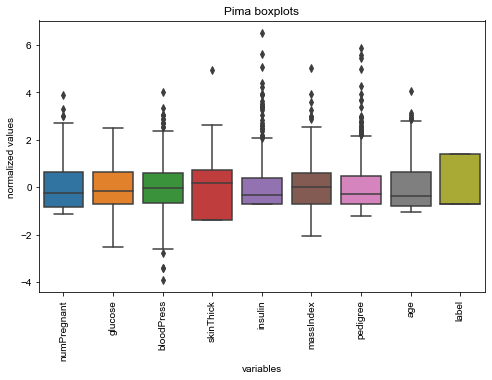

In [9]:
########## feature boxplots 
df_pima_normalizado = (df_pima - df_pima.mean()) / df_pima.std() #normalizar para tener rangos uniformes en histogramas

plt.figure( figsize=(8, 5))
plt.title("Pima boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df_pima_normalizado)
#bx_plot = sns.boxplot(data=df_housing)
plt.xticks(rotation=90)
plt.xlabel("variables")
plt.ylabel("normalized values")
plt.show()

### Histograms and scatterplots

Plot histograms of groups of all variables plus target.

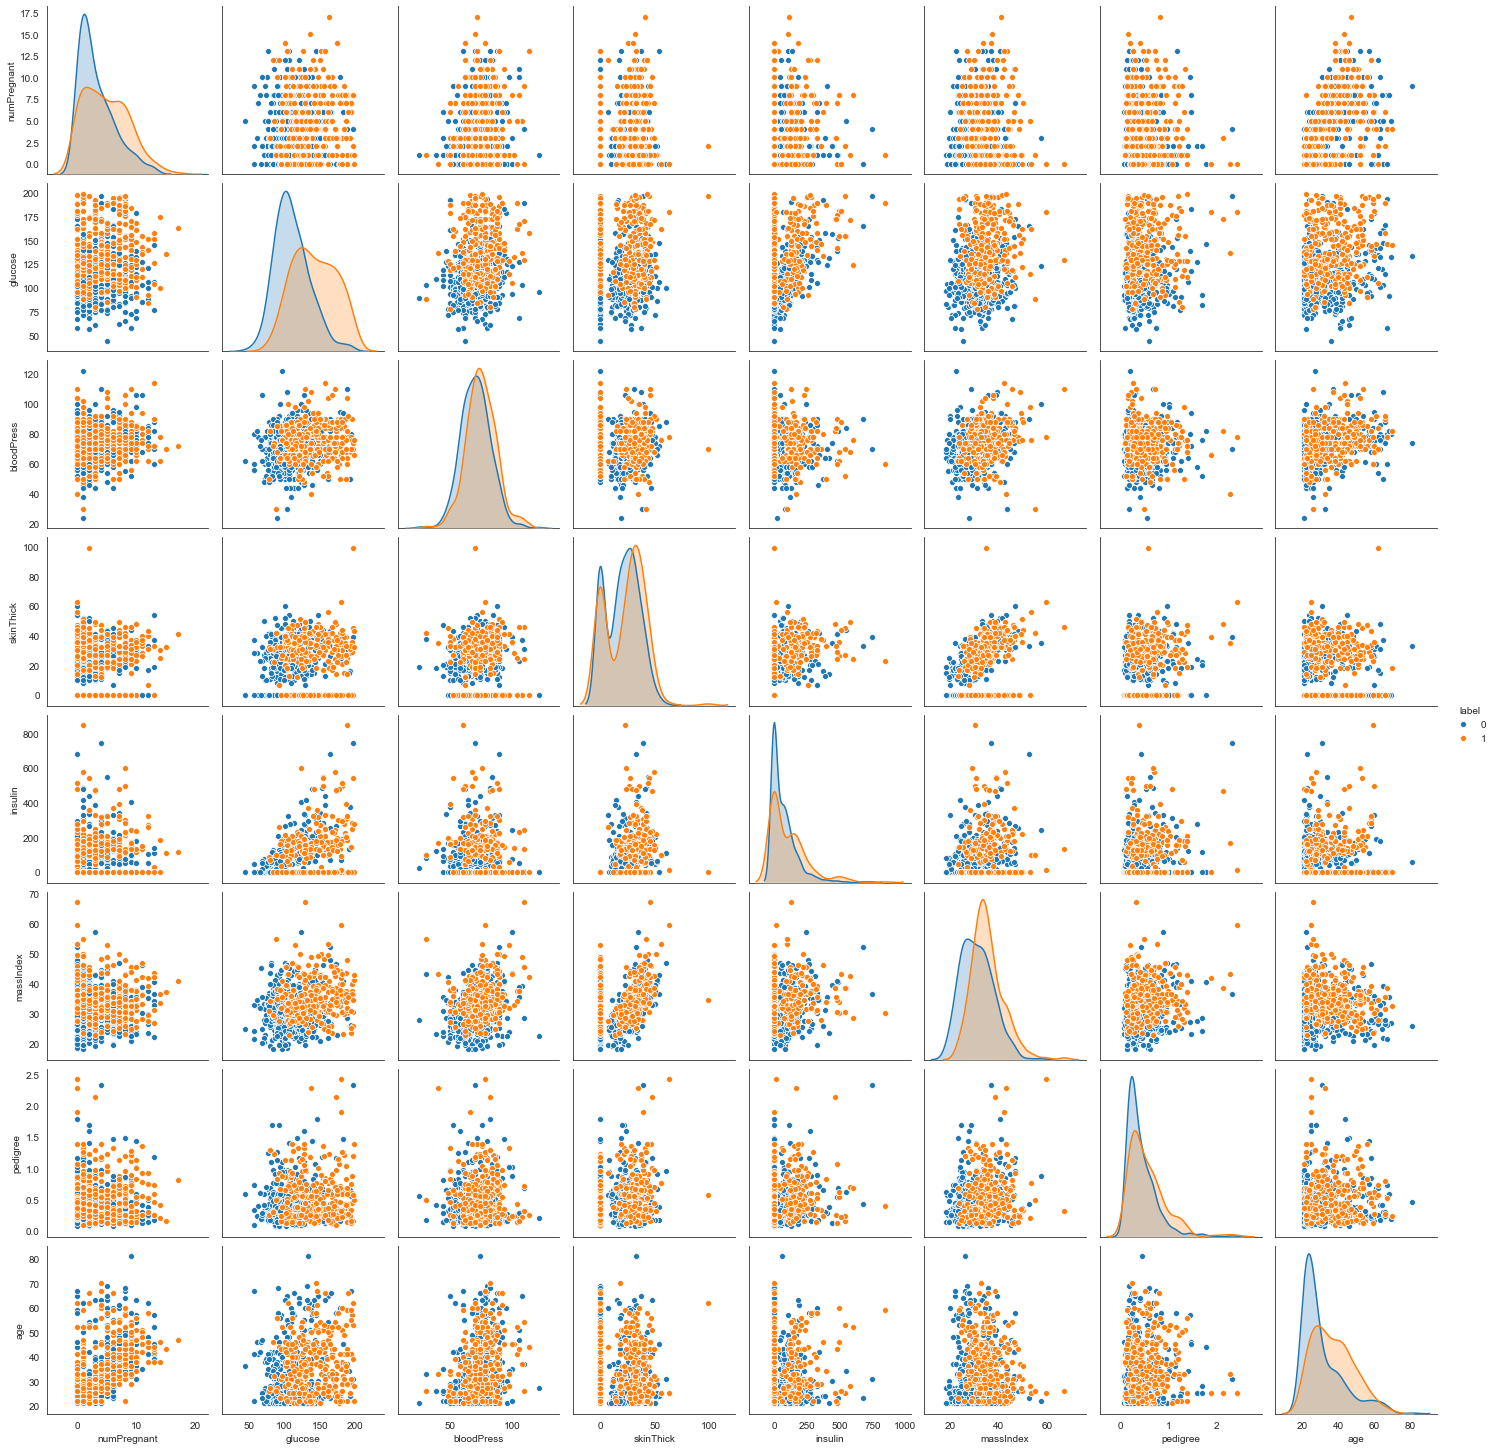

In [10]:
pair_plot = sns.pairplot( df_pima , hue= 'label', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

We always check scatterplots and correlations, but now their relationship with the 0, 1 target is now less relevant.

### Positive vs Negative Feature Histograms

A classification problem is more or less solvable depending on the overlap of patterns across classes.

We check this for each feature.

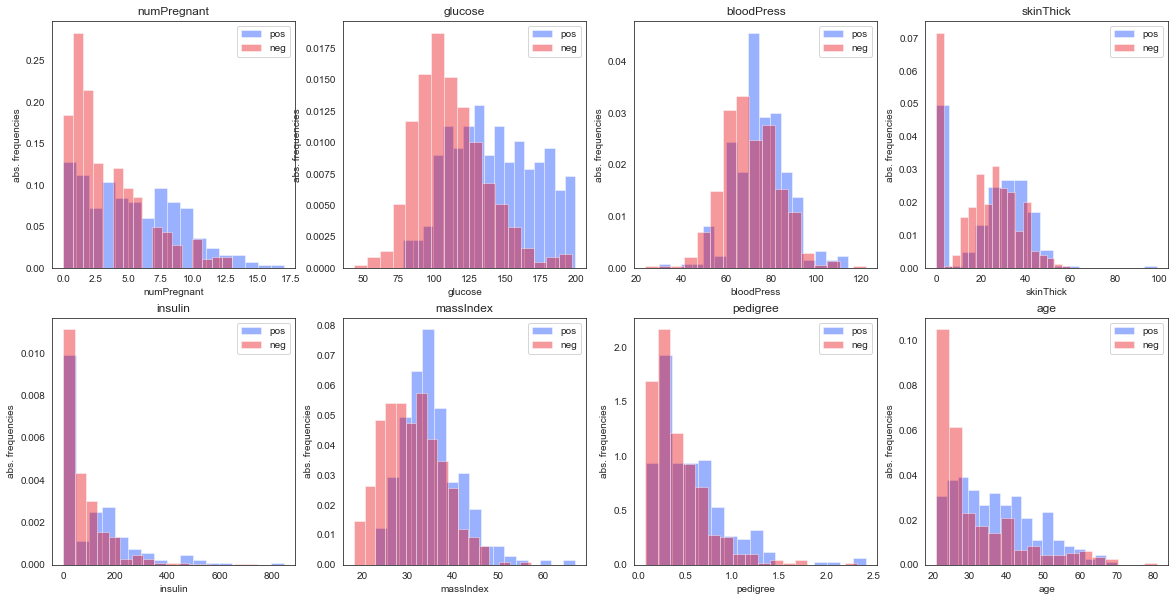

In [11]:
# But it's better to have the positive and negative histograms together

#sns.set(color_codes=True)
sns.set_color_codes("bright")
sns.set_style("white")

num_columns = 4
num_rows = 2
bins = 17

plt.figure( figsize=(20, 5*num_rows))
plt.title("Pima positive vs negative histograms")

pos = np.where( df_pima[target_pima] == 1)[0]
neg = np.where( df_pima[target_pima] == 0)[0]
    
for i, var in enumerate (['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']):
    ax = plt.subplot(num_rows, num_columns, i+1)
    ax.set_title(var)
    #plt.hist( df_pima[ var ].iloc[pos], bins=bins, color='b', label='pos', alpha=0.5)
    #plt.hist( df_pima[ var ].iloc[neg], bins=bins, color='r', label='neg', alpha=0.5)

    sns.distplot( df_pima[ var ].iloc[pos], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
    sns.distplot( df_pima[ var ].iloc[neg], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
    
    plt.ylabel("abs. frequencies")
    plt.legend(loc='best')

plt.show()

## Correlations

We drop the `label` column.

In [12]:
df_pima[['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']].corr().round(decimals=3)

,numPregnant,glucose,bloodPress,skinThick,insulin,massIndex,pedigree,age
numPregnant,1.000,0.135,0.210,-0.096,-0.080,0.012,-0.026,0.557
glucose,0.135,1.000,0.223,0.074,0.338,0.223,0.137,0.264
bloodPress,0.210,0.223,1.000,0.012,-0.047,0.287,-0.000,0.325
skinThick,-0.096,0.074,0.012,1.000,0.421,0.402,0.176,-0.129
insulin,-0.080,0.338,-0.047,0.421,1.000,0.192,0.183,-0.049
massIndex,0.012,0.223,0.287,0.402,0.192,1.000,0.155,0.021
pedigree,-0.026,0.137,-0.000,0.176,0.183,0.155,1.000,0.023
age,0.557,0.264,0.325,-0.129,-0.049,0.021,0.023,1.000


An image (or a heatmap) is worth a thousand words.

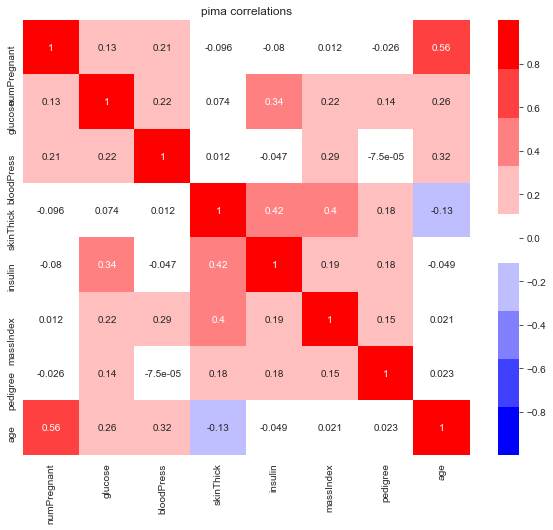

In [13]:
# define color map
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# define heatmap figure
plt.figure( figsize=(10, 8))
plt.title('pima correlations')
h_map = sns.heatmap(df_pima[['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age']].corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    xticklabels=list(df_pima.columns[ : -1]),
                    yticklabels=list(df_pima.columns[ : -1]))
plt.xticks(rotation=90) 

# put ticks on the color map bar
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# fix a few things
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

# generate the picture
plt.show()

## SV Classifier

We build a first a pipeline model with default values to be hyperparameterized later.

We will work with Gaussian kernels, so we have to set two hyperparameters, `C, gamma`. We also set the `probability` flag as `True`, as SVM needs extra computation to predict probabilities.

In [14]:
x = df_pima[ vars_pima ].values
y = df_pima[ target_pima ].values
num_patterns, dim = x.shape

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# scaler + svc pipeline
mm_sc = MinMaxScaler()
svc = SVC(kernel='rbf', 
          shrinking=False, 
          probability=True,
          tol=1.e-3)

inner_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                  ('svc', svc)])

inner_estimator.fit(x, y)

Pipeline(memory=None,
         steps=[('minmax_sc', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=False, tol=0.001,
                     verbose=False))],
         verbose=False)

In [16]:
svc = inner_estimator.named_steps['svc']

print("num_SVs_per_class:", svc.n_support_)
print("indices_of_svs:   ", svc.support_[ : 10])
print("intercept:        ", svc.intercept_)
print("num SVs_at_bound: ", (abs(svc.dual_coef_) == svc.C).sum())
print("num_SVs:          ", (np.logical_and(abs(svc.dual_coef_) < svc.C, 
                                            abs(svc.dual_coef_) > 0.).sum()))

print("svs:              ", svc.support_vectors_[ : 10, : ])

print("dual_coefs:       ", svc.dual_coef_[ 0, : 10])

num_SVs_per_class: [197 192]
indices_of_svs:    [ 8 10 15 17 18 25 26 27 31 32]
intercept:         [-0.16171946]
num SVs_at_bound:  350
num_SVs:           39
svs:               [[0.23529412 0.42580645 0.69387755 0.         0.         0.39672802
  0.04824936 0.15      ]
 [0.58823529 0.61290323 0.57142857 0.         0.         0.18200409
  0.58198121 0.6       ]
 [0.05882353 0.38064516 0.06122449 0.38383838 0.09810875 0.51329243
  0.04483348 0.2       ]
 [0.17647059 0.52903226 0.65306122 0.41414141 0.27777778 0.43149284
  0.26729291 0.1       ]
 [0.47058824 0.35483871 0.6122449  0.         0.         0.35173824
  0.1323655  0.48333333]
 [0.76470588 0.6516129  0.59183673 0.19191919 0.13002364 0.08179959
  0.07130658 0.6       ]
 [0.29411765 0.47096774 0.69387755 0.         0.         0.32515337
  0.11058924 0.28333333]
 [0.29411765 0.41935484 0.52040816 0.26262626 0.         0.36400818
  0.19982921 0.65      ]
 [0.58823529 0.50322581 0.55102041 0.31313131 0.         0.19222904
  0.1853117

### Can we overfit a SVM?

It's easy: just set a large `C` (i.e., very little regularization) and a big `gamma` (i.e., use sharp Gaussians).

We do so and predict over the same train set.

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

svc = SVC(C=1.e5, 
          kernel='rbf', 
          gamma=1.e3/dim, 
          probability=True,
          shrinking=False, 
          tol=1.e-3)

inner_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                  ('svc', svc)])

inner_estimator.fit(x, y)
y_pred = inner_estimator.predict(x)

print("acc: %.4f" % accuracy_score(y,y_pred),
      "recall: %.4f" % recall_score(y, y_pred), 
      "precision: %.4f" % precision_score(y, y_pred))

print("num_SVs_per_class:", inner_estimator.named_steps["svc"].n_support_)

acc: 1.0000 recall: 1.0000 precision: 1.0000
num_SVs_per_class: [475 249]


But if we do a realistic model evaluation ...

In [18]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedShuffleSplit

sssf = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

cv_acc_best = cross_val_score(inner_estimator, x, y, cv=sssf, scoring='accuracy', n_jobs=2)
print("\ncv mean accuracy: %.3f" % (cv_acc_best.mean()))

cv_recall_best = cross_val_score(inner_estimator, x, y, cv=sssf, scoring='recall', n_jobs=2)
print("\ncv mean recall: %.3f" % (cv_recall_best.mean()))

cv_precision_best = cross_val_score(inner_estimator, x, y, cv=sssf, scoring='precision', n_jobs=2)
print("\ncv mean precision: %.3f" % (cv_precision_best.mean()))


cv mean accuracy: 0.650

cv mean recall: 0.010

cv mean precision: 0.667


## Hyperparametrization of $C, \gamma$

We do it by grid search CV, but we have to explore **two** hyperparameters, so search times may increase considerably.

We will use 5 folds.

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-5, 4)]) / dim)

param_grid ={'svc__C': l_C,
             'svc__gamma': l_gamma}

print("num_hyperparams", len(l_C) * len(l_gamma))

n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=skf, 
                            scoring='accuracy', 
                            refit=True,
                            n_jobs=2,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("c_gamma_cv_search_pima.plk", 'wb') 
pickle.dump(cv_estimator, f_pkl)
f_pkl.close()

num_hyperparams 63
Fitting 10 folds for each of 63 candidates, totalling 630 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 330 tasks      | elapsed:   29.0s


grid_search_time: 124.599533 segundos


[Parallel(n_jobs=2)]: Done 630 out of 630 | elapsed:  2.1min finished


## Analyzing GridSearchCV results

We check the adequacy of the best hyperparameters with respect to the grid range.

In [20]:
f_pkl = open("c_gamma_cv_search_pima.plk", 'rb') 
cv_estimator = pickle.load(f_pkl)
f_pkl.close()

In [21]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", cv_estimator.best_params_['svc__C']) 

print("gamma_range: %.5f - %.0f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", cv_estimator.best_params_['svc__gamma'])

C_range: 0.0010 - 1000
	best_C: 1.0
gamma_range: 0.00391 - 1
	best_gamma: 1.0


We sort hyperparameters by best CV test score

In [22]:
df_C_gamma_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_C_gamma_search.sort_values(by='mean_test_score', ascending=False)[['param_svc__C', 'param_svc__gamma', 'mean_test_score']][ : 5]

,param_svc__C,param_svc__gamma,mean_test_score
35,1,1,0.776332
33,1,0.25,0.774981
47,100,0.015625,0.773573
34,1,0.5,0.773573
41,10,0.125,0.772184


Next we plot the CV errors with respect to `C` and `gamma`.

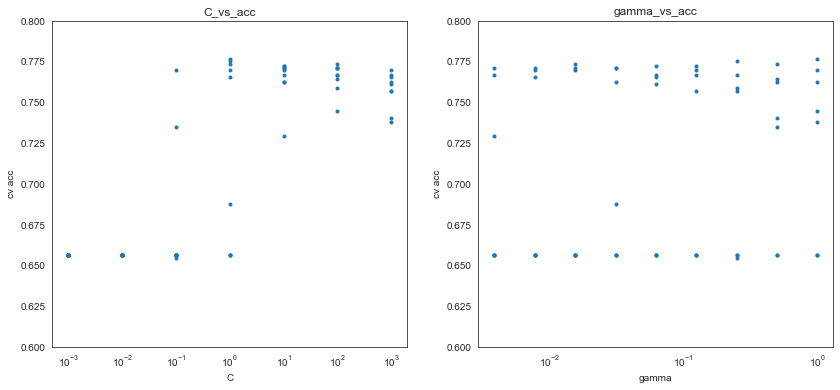

In [23]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('C_vs_acc')
plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
plt.ylim(0.6, 0.8)
_ = plt.plot( df_C_gamma_search['param_svc__C'], df_C_gamma_search['mean_test_score'], '.')

plt.subplot(1, 2, 2)
plt.title('gamma_vs_acc')
plt.xlabel('gamma')
plt.ylabel('cv acc')
plt.xscale('log')
plt.ylim(0.6, 0.8)
_ = plt.plot( df_C_gamma_search['param_svc__gamma'], df_C_gamma_search['mean_test_score'], '.')
plt.show()

This less clear than for logistic regression, as there are five `gamma` values for each `C` and viceversa.

We can try to fix a hyperparameter to its optimal value and then draw the other, although we can miss some optimal or near optimal combinations.

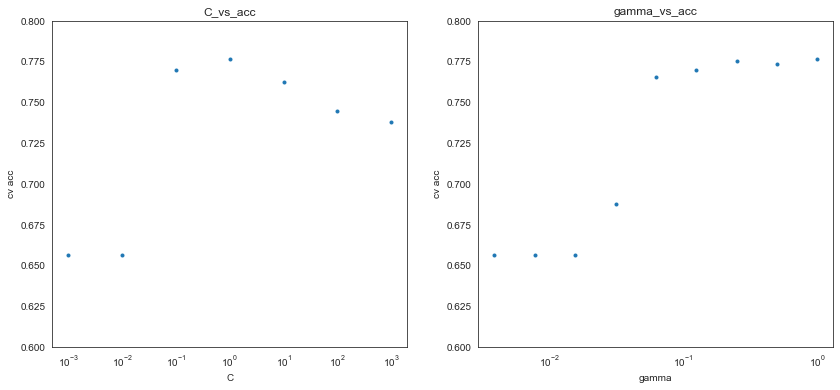

In [24]:
best_C = cv_estimator.best_params_['svc__C']
best_gamma = cv_estimator.best_params_['svc__gamma']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('C_vs_acc')
plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
plt.ylim(0.6, 0.8)
idx_best_gamma = df_C_gamma_search['param_svc__gamma'] == best_gamma
_ = plt.plot( df_C_gamma_search[idx_best_gamma]['param_svc__C'], df_C_gamma_search[idx_best_gamma]['mean_test_score'], '.')

plt.subplot(1, 2, 2)
plt.title('gamma_vs_acc')
plt.xlabel('gamma')
plt.ylabel('cv acc')
plt.xscale('log')
plt.ylim(0.6, 0.8)
idx_best_C = df_C_gamma_search['param_svc__C'] == best_C
_ = plt.plot( df_C_gamma_search[idx_best_C]['param_svc__gamma'], df_C_gamma_search[idx_best_C]['mean_test_score'], '.')
plt.show()

This less clear than for logistic regression, as there are five `gamma` values for each `C` and viceversa.

We try an alternative heatmap representation.

### C vs $\gamma$ accuracy plot

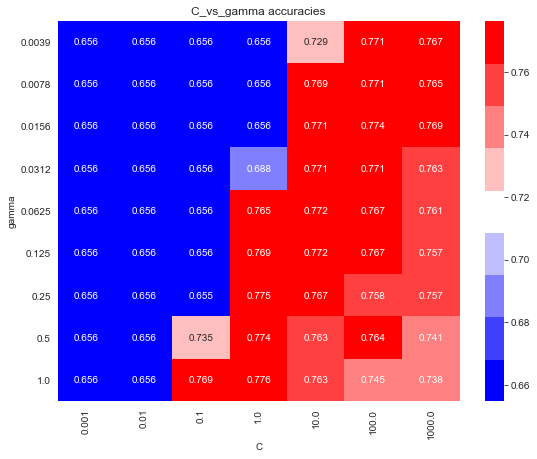

In [25]:
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

plt.figure( figsize=(9, 7))
plt.title('C_vs_gamma accuracies')

m_t_s = df_C_gamma_search.sort_values(by=['param_svc__gamma', 'param_svc__C'])['mean_test_score'].values.reshape(len(l_gamma), -1)
h_map = sns.heatmap(m_t_s, 
                    cmap=cMap, 
                    annot=True, 
                    fmt=".3f",
                    xticklabels=l_C,
                    yticklabels=np.round(l_gamma, decimals=4))

plt.xlabel('C')
plt.ylabel('gamma')
plt.xticks(rotation='vertical')
plt.yticks(rotation=0)

cbar = h_map.collections[0].colorbar
l_ticks = [0.6 + k/100. for k in range(0, 21, 2)]
cbar.set_ticks(l_ticks)

bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

### Structure of best model

In [26]:
best_model = cv_estimator.best_estimator_
svc = best_model.named_steps['svc']

In [27]:
print("num_svs_per_class:", svc.n_support_)
print("dual_coefs:       ", svc.dual_coef_[0, : 10])

num_svs_per_class: [196 198]
dual_coefs:        [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


### Accuracy, recall and precision of best model

We use first `cross_val_score`   
We also change the fold generator to `StratifiedShuffleSplit`. It generates random train-validation folds but they are not disjoint anymore.

In [28]:
sssf = StratifiedShuffleSplit(n_splits=10, test_size=0.2)

cv_acc_best = cross_val_score(best_model, x, y, cv=sssf, scoring='accuracy', n_jobs=2)
print("\ncv mean (std) accuracy:  \t %.3f (%.3f)" % (cv_acc_best.mean(), cv_acc_best.std()))

cv_recall_best = cross_val_score(best_model, x, y, cv=sssf, scoring='recall', n_jobs=2)
print("\ncv mean (std) recall:    \t %.3f (%.3f)" % (cv_recall_best.mean(), cv_recall_best.std()))

cv_precision_best = cross_val_score(best_model, x, y, cv=sssf, scoring='precision', n_jobs=2)
print("\ncv mean (std) precision: \t %.3f (%.3f)" % (cv_precision_best.mean(), cv_precision_best.std()))


cv mean (std) accuracy:  	 0.772 (0.019)

cv mean (std) recall:    	 0.504 (0.045)

cv mean (std) precision: 	 0.730 (0.049)


We use next `cross_val_predict`.

In [29]:
y_pred = cross_val_predict(best_model, x, y, cv=StratifiedKFold(n_folds), n_jobs=2)

print("accuracy:  %.3f" % accuracy_score(y, y_pred))
print("recall:    %.3f" % recall_score(y, y_pred))
print("precision: %.3f" % precision_score(y, y_pred))

accuracy:  0.768
recall:    0.530
precision: 0.721


## Predicting probabilities

In classification we should give class probability estimates rather than labels.

To do so, we can build the histogram of the posterior probabilities predicted for the positive class and decide on adequate thresholds.

In [30]:
######### plot prob histograms
p_pred = cross_val_predict(best_model, x, y, cv=StratifiedKFold(n_folds, shuffle=True),
                           method='predict_proba', n_jobs=2)

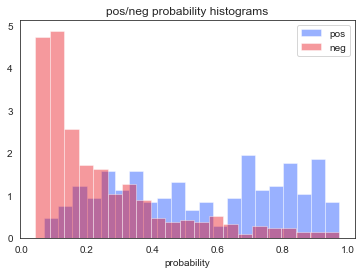

In [31]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.title("pos/neg probability histograms")
plt.xlabel("probability")
#plt.hist( p_pred[pos, 1], bins=bins, color='b', label='pos', alpha=0.5)
#plt.hist( p_pred[neg, 1], bins=bins, color='r', label='neg', alpha=0.5)

sns.distplot( p_pred[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
    
plt.legend(loc='best')
plt.show()

## Applying classification models

We explore again the effect on the classification performance of lowering the decision threshold for positives below 0.5.

In [32]:
######### threshold analysis

l_thresholds = [0.5, 0.4, 0.3, 0.2]

for thresh in l_thresholds:
    y_pred_thresh = np.zeros( num_patterns ) 
    pos_thresh = np.where(p_pred[ :, 1] > thresh)[0]
    y_pred_thresh[pos_thresh] = 1

    print("threshold:", thresh)
    print("\tconfusion matrix\n", confusion_matrix(y, y_pred_thresh) )
    print("\n\taccuracy\t%.3f"   %   accuracy_score(y, y_pred_thresh) )
    print("\trecall\t\t%.3f"     %   recall_score(y, y_pred_thresh) )
    print("\tprecision\t%.3f"    %   precision_score(y, y_pred_thresh) )
    print("\tnum_alertas\t%d\n\n"    %   confusion_matrix(y, y_pred_thresh)[ : , 1 ].sum() )

threshold: 0.5
	confusion matrix
 [[418  57]
 [115 134]]

	accuracy	0.762
	recall		0.538
	precision	0.702
	num_alertas	191


threshold: 0.4
	confusion matrix
 [[395  80]
 [ 86 163]]

	accuracy	0.771
	recall		0.655
	precision	0.671
	num_alertas	243


threshold: 0.3
	confusion matrix
 [[347 128]
 [ 54 195]]

	accuracy	0.749
	recall		0.783
	precision	0.604
	num_alertas	323


threshold: 0.2
	confusion matrix
 [[279 196]
 [ 26 223]]

	accuracy	0.693
	recall		0.896
	precision	0.532
	num_alertas	419


